In [1]:
import torch
from torchvision import datasets        
import torchvision.transforms as transforms

/home/millliono/miniconda3/envs/dev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST(root='./data', train=True,
                          transform=transform, download=True)
testset = datasets.MNIST(root='./data', train=False,
                         transform=transform, download=True)

print("trainset: ", len(trainset))
print("testset: ", len(testset))
# print(trainset[123])

batch_size = 32
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=6)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=True, num_workers=6)

for X, y in testloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

trainset:  60000
testset:  10000
Shape of X [N, C, H, W]: torch.Size([32, 1, 28, 28])
Shape of y: torch.Size([32]) torch.int64


In [3]:
from torch import nn
from torch import optim
import torch.nn.functional as F

In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
             nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 784),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [5]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, X.reshape(-1, 28*28))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss = loss.item()
            current = batch * len(X)
            print(f"loss(batch): {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()

    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, X.reshape(-1, 28*28)).item()

    print(f"Test Error: \nAvg loss(batch): {test_loss/num_batches:>8f} \n")

In [8]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}  (batch_size={batch_size}, lr={lr})\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer)
    test(testloader, model, loss_fn)

Epoch 1  (batch_size=32, lr=0.001)
-------------------------------
loss(batch): 0.230779  [    0/60000]
loss(batch): 0.064072  [ 3200/60000]
loss(batch): 0.064254  [ 6400/60000]
loss(batch): 0.054702  [ 9600/60000]
loss(batch): 0.047896  [12800/60000]
loss(batch): 0.041109  [16000/60000]
loss(batch): 0.034653  [19200/60000]
loss(batch): 0.037003  [22400/60000]
loss(batch): 0.032116  [25600/60000]
loss(batch): 0.029559  [28800/60000]
loss(batch): 0.035651  [32000/60000]
loss(batch): 0.029285  [35200/60000]
loss(batch): 0.027009  [38400/60000]
loss(batch): 0.023544  [41600/60000]
loss(batch): 0.022850  [44800/60000]
loss(batch): 0.022039  [48000/60000]
loss(batch): 0.023070  [51200/60000]
loss(batch): 0.025838  [54400/60000]
loss(batch): 0.023975  [57600/60000]
Test Error: 
Avg loss(batch): 0.024374 

Epoch 2  (batch_size=32, lr=0.001)
-------------------------------
loss(batch): 0.023876  [    0/60000]
loss(batch): 0.025318  [ 3200/60000]
loss(batch): 0.023025  [ 6400/60000]
loss(batch)

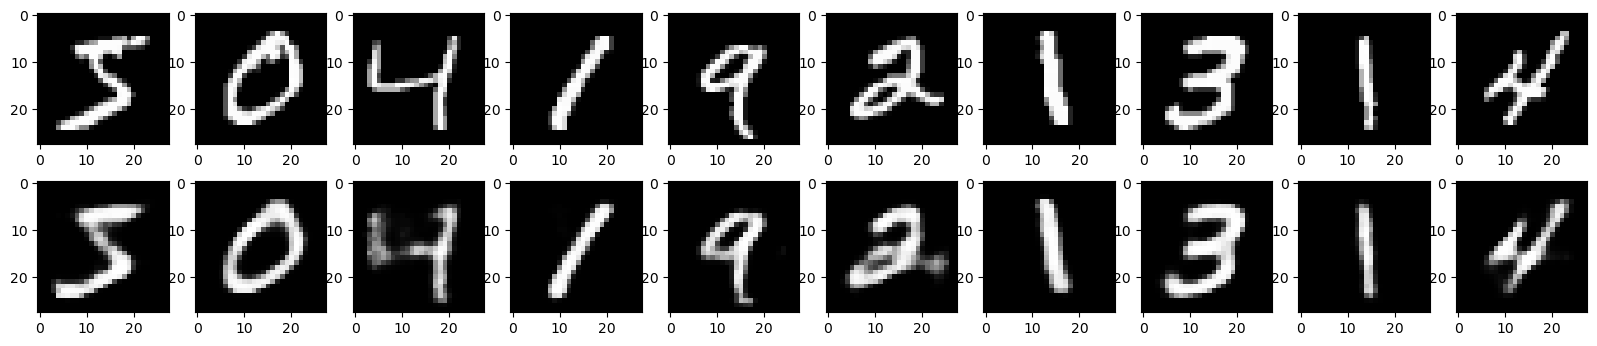

In [10]:
# visualization
import matplotlib.pyplot as plt

n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(trainset[i][0].reshape(28,28))
    plt.gray()

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(model(trainset[i][0].to(device)).cpu().detach().numpy().reshape(28,28))
    plt.gray()
plt.show()
